# Solving ODEs with scipy.integrate.solve_ivp

## Solving ordinary differential equations (ODEs)

Here we will revisit the differential equations solved in 5300_Jupyter_Python_intro_01.ipynb with `odeint`, only now we'll use `solve_ivp` from Scipy.  We'll compare the new and old solutions as we go.

### First-order ODE

In [2]:
# Import the required modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import solve_ivp   # Now preferred to odeint

Let's try a one-dimensional first-order ODE, say:

$\begin{align}
\quad 
\frac{dv}{dt} = -g, \quad \mbox{with} \quad v(0) = 10
\end{align}$

in some appropriate units (we'll use MKS units by default).  This ODE can be separated and directly integrated:

$\begin{align}
  \int_{v_0=10}^{v} dv' = - g \int_{0}^{t} dt'
  \quad\Longrightarrow\quad
    v - v_0 = - g (t - 0)
  \quad\Longrightarrow\quad
   v(t) = 10 - gt
\end{align}$



The goal is to find the solution $v(t)$ as an array `v_pts` at the times in the array `t_pts`.

In [3]:
def U(Phi, m):
    """return potential over M g R"""
    return (-np.cos(Phi)-m*Phi)

phi_pts = (np.linspace(-np.pi, 4*np.pi, 200))
pot = []

mass=[.5,.7,.99]
for i, m in enumerate(mass):
    pot.append(U(Phi=phi_pts, m=m))
    


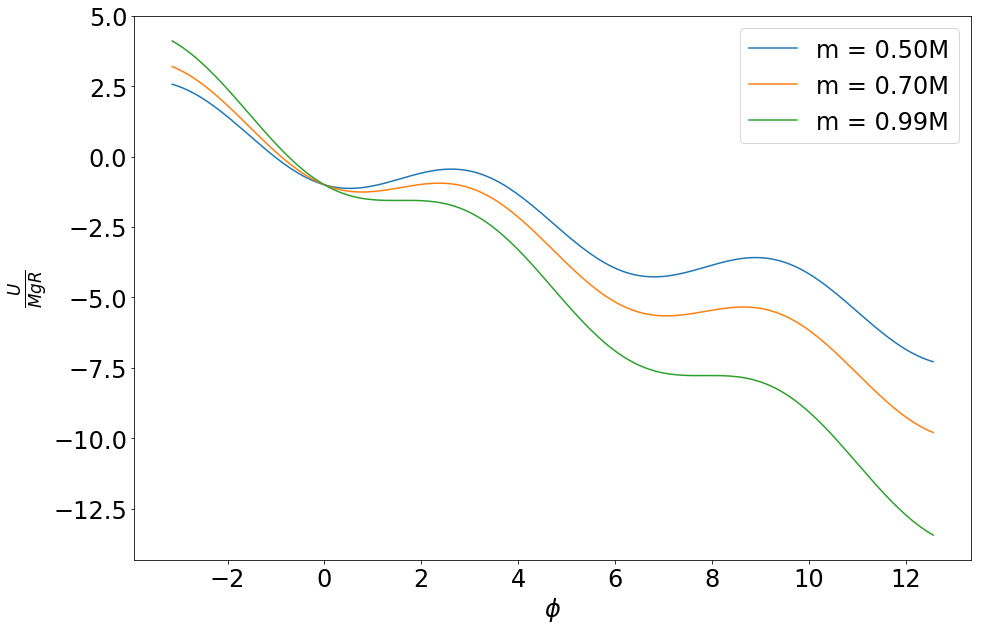

In [4]:
mpl.rcParams.update({'font.size':24})
fig = fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(1,1,1)

ax.plot(phi_pts,pot[0],label=rf'm = {mass[0]:.2f}M')

ax.plot(phi_pts,pot[1],label=rf'm = {mass[1]:.2f}M')

ax.plot(phi_pts,pot[2],label=rf'm = {mass[2]:.2f}M')
ax.legend()
ax.set_xlabel(r'$\phi$')
ax.set_ylabel(r'$\frac{U}{MgR}$');

#fig.savefig('potential.png',bbox_inches='tight')

Here's how we did it before with odeint:

Differences between `solve_ivp` and `odeint`:
* `dv_dt(t, v)`  vs.  `dv_dt(v, t)`, i.e., the function definitions have the arguments reversed.
* With `odeint`, you only specify the full array of $t$ points you want to know $v(t)$ at.  With `solve_ivp`, you first specify the starting $t$ and ending $t$ as a tuple: `(t_start, t_end)` and then (optionally) specify `t_eval=t_pts` to evaluate $v$ at the points in the `t_pts` array.
* `solve_ivp` returns an object from which $v(t)$ (and other results) can be found, while `ode_int` returns $v(t)$.
* For this single first-order equation, $v(t)$ is returned for the $N$ requested $t$ points as a $1 \times N$ two-dimensional array by `solve_ivp` and as a $N \times 1$ array by `odeint`.
* `odeint` has no choice of solver while the `solve_ivp` solver can be set by `method`.  The default is `method='RK45'`, which is good, general-purpose Runge-Kutta solver.  

### Second-order ODE

Suppose we have a second-order ODE such as:

$$
\quad y'' + 2 y' + 2 y = \cos(2x), \quad \quad y(0) = 0, \; y'(0) = 0
$$

We can turn this into two first-order equations by defining a new dependent variable. For example,

$$
\quad z \equiv y' \quad \Rightarrow \quad z' + 2 z + 2y = \cos(2x), \quad z(0)=y(0) = 0.
$$

Now introduce the vector 

$$
  \mathbf{U}(x) = \left(\begin{array}{c}
                         y(x) \\
                         z(x)
                        \end{array}
                  \right)
        \quad\Longrightarrow\quad
    \frac{d\mathbf{U}}{dx} = \left(\begin{array}{c}
                                    z \\
                                    -2 y' - 2 y + \cos(2x)
                                   \end{array}
                             \right) 
$$

We can solve this system of ODEs using `solve_ivp` with lists, as follows.  We will try it first without specifying the relative and absolute error tolerances rtol and atol.

In [36]:
# Define a function for the right side
def dU_dx_new(x, U, l=1., w=.2, R=.2, g=1):
    """Right side of the differential equation to be solved.
    U is a two-component vector with y=U[0] and z=U[1]. 
    Thus this function should return [y', z']
    """
    return [U[1], (-g/l)*np.sin(U[0])+R*w**2/l * np.cos(U[0]-w*x)]

#def theta(x, bigOmega, theta_0, ep):
 #   return theta_0 + ep*np.cos(bigOmega*x)


# initial condition U_0 = [y(0)=0, z(0)=y'(0)=0]

x_pts = (np.linspace(0, 20, 200))  # Set up the mesh of x points
U_0 = [0.2, 0.]

result = solve_ivp(dU_dx_new, (0, 20), U_0, t_eval=x_pts)
y_pts = (result.y[0,:])   # Ok, this is tricky.  For each x, result.y has two 
                            #  components.  We want the first component for all
                            #  x, which is y(x).  The 0 means the first index and 
                            #  the : means all of the x values.


x_pts2 = (np.linspace(0, 100, 1000))  # Set up the mesh of x points
U_0 = [0.2, 0.]

result = solve_ivp(dU_dx_new, (0, 200), U_0, t_eval=x_pts2)
y_pts2 = (result.y[0,:])   # Ok, this is tricky.  For each x, result.y has two 
                            #  components.  We want the first component for all
                            #  x, which is y(x).  The 0 means the first index and 
                            #  the : means all of the x values.

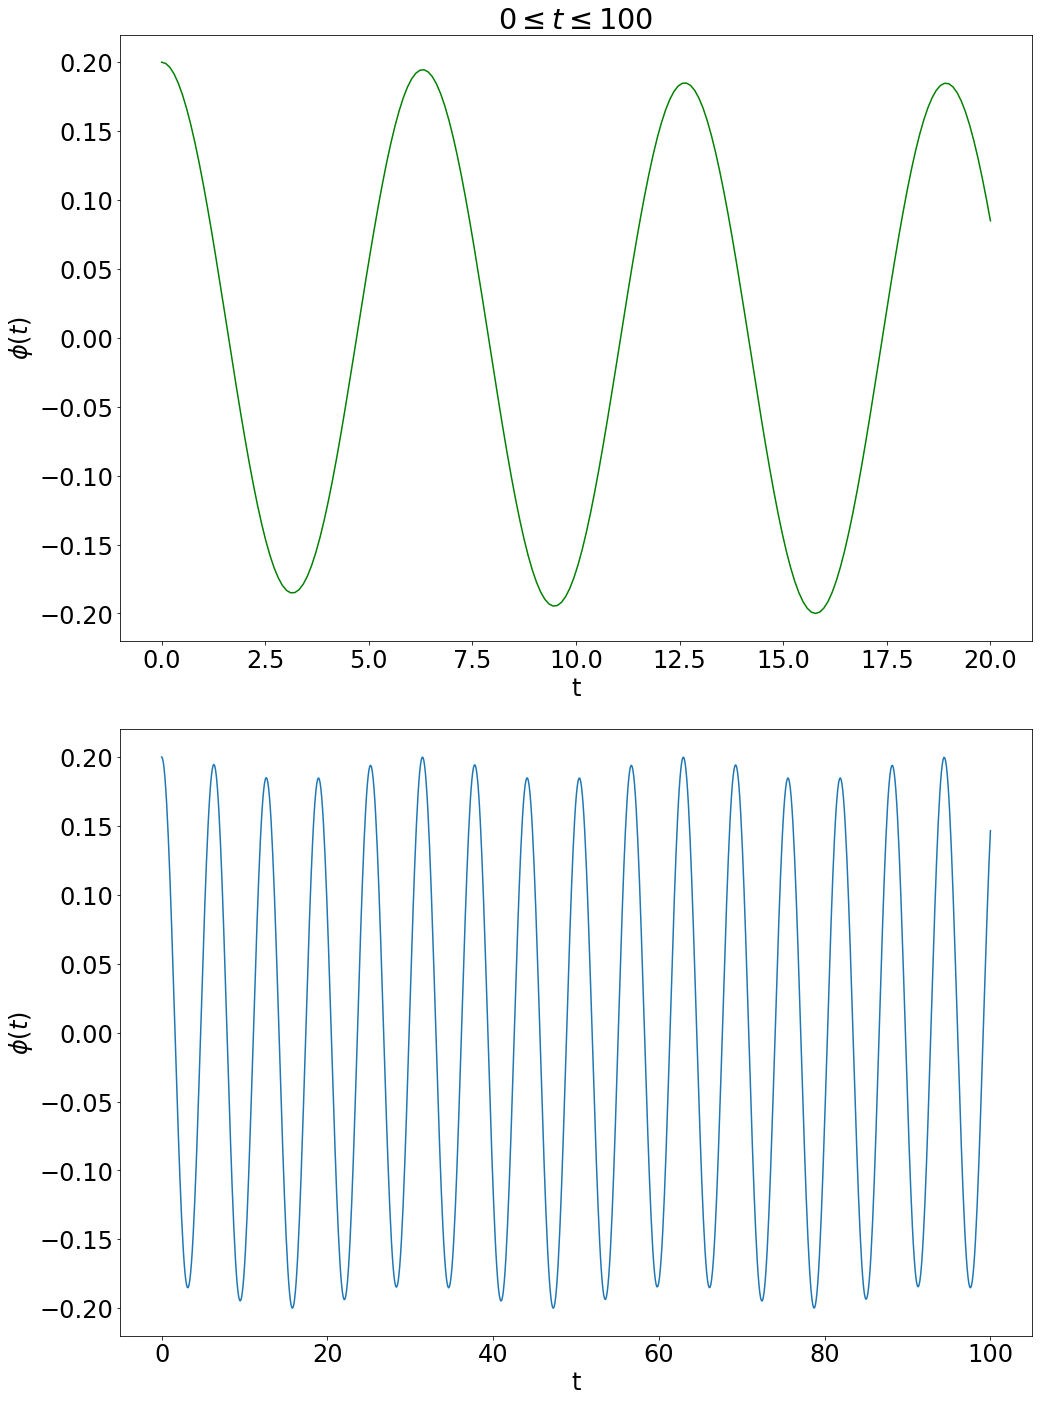

In [40]:
mpl.rcParams.update({'font.size':24})
fig = fig = plt.figure(figsize=(15,20))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

ax1.plot(x_pts,y_pts, 'green')
ax1.set_title(f'$0 \leq t \leq 20 $')
ax1.set_xlabel('t')
ax1.set_ylabel(r'$\phi (t)$')

ax2.plot(x_pts2,y_pts2)
ax2.set_xlabel('t')

ax2.set_ylabel(r'$\phi (t)$')
ax1.set_title(f'$0 \leq t \leq 100 $')
fig.tight_layout()
fig.savefig('Taylor_7.44.png',bbox_inches='tight')

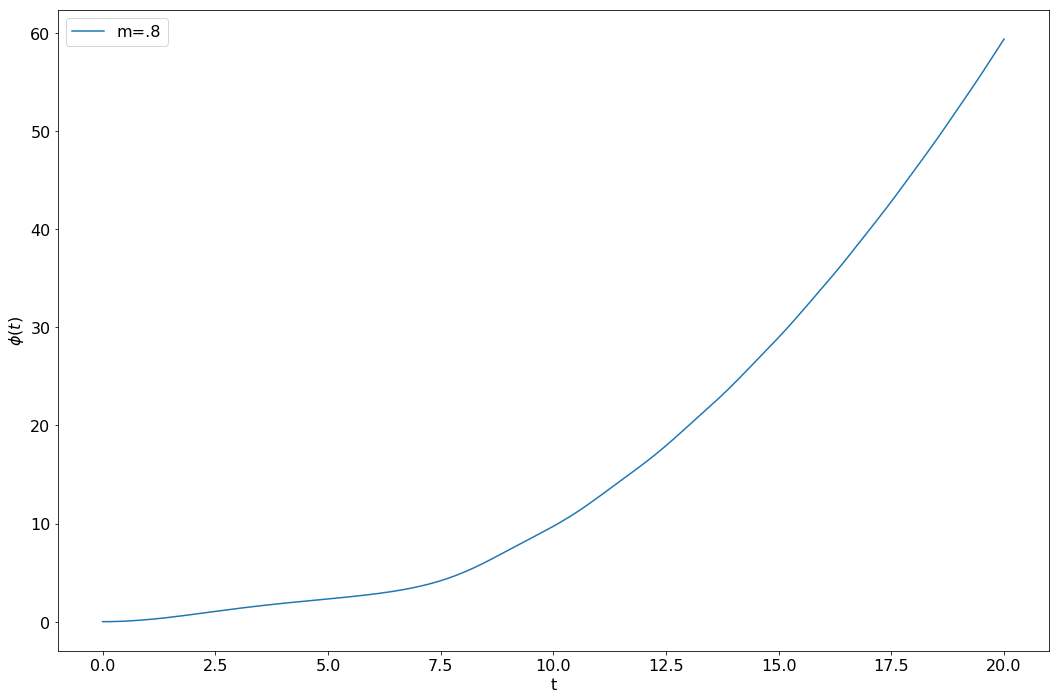

In [31]:
# Define a function for the right side
def dU_dx_new(x, U, m=.8, M=1., g=1., R=1.):
    """Right side of the differential equation to be solved.
    U is a two-component vector with y=U[0] and z=U[1]. 
    Thus this function should return [y', z']
    """
    return [U[1], (1/((m+M)*R))*(m*g-M*g*np.sin(U[0]))]

#def theta(x, bigOmega, theta_0, ep):
 #   return theta_0 + ep*np.cos(bigOmega*x)


# initial condition U_0 = [y(0)=0, z(0)=y'(0)=0]

x_pts = (np.linspace(0, 20, 200))  # Set up the mesh of x points
#y_pts=[]
#y_ptsapp=[]

#rad = np.pi*(ep+60.)/180
U_0 = [0., 0.]

result = solve_ivp(dU_dx_new, (0, 20), U_0, t_eval=x_pts)
y_pts = (result.y[0,:])   # Ok, this is tricky.  For each x, result.y has two 
                            #  components.  We want the first component for all
                            #  x, which is y(x).  The 0 means the first index and 
                            #  the : means all of the x values.
mpl.rcParams.update({'font.size':16})
fig = fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(x_pts,y_pts,label='m=.8')
#ax1.plot(x_pts, np.pi/3 + np.pi/180*np.cos(bigOmega*x_pts),label ='approx.')
#ax1.set_title(f'$\epsilon = 1.0 degree$')
ax1.legend()
ax1.set_xlabel('t')
ax1.set_ylabel(r'$\phi (t)$')

fig.tight_layout()
fig.savefig('Taylor_7.43d.png',bbox_inches='tight')

Here's how we did it before with `odeint`:

In [16]:
# Define a function for the right side
def dU_dx(U, x):
    """Right side of the differential equation to be solved.
    U is a two-component vector with y=U[0] and z=U[1]. 
    Thus this function should return [y', z']
    """
    return [U[1], -2*U[1] - 2*U[0] + np.cos(2*x)]

# initial condition U_0 = [y(0)=0, z(0)=y'(0)=0]
U_0 = [0., 0.]

x_pts = np.linspace(0, 15, 20)  # Set up the mesh of x points
U_pts = odeint(dU_dx, U_0, x_pts)  # U_pts is a 2-dimensional array
y_pts_odeint = U_pts[:,0]  # Ok, this is tricky.  For each x, U_pts has two 
                           #  components.  We want the upper component for all
                           #  x, which is y(x).  The : means all of the first 
                           #  index, which is x, and the 0 means the first
                           #  component in the other dimension.

Make a table comparing results (using `flatten()` to make the matrices into arrays):

In [17]:
print('    x     y(x) [solve_ivp]    y(x) [odeint]')
for x, y_solve_ivp, y_odeint in zip(x_pts, 
                                    y_pts.flatten(), 
                                    y_pts_odeint.flatten()):
    print(f' {x:6.3f}   {y_solve_ivp:12.7f}       {y_odeint:12.7f}')

    x     y(x) [solve_ivp]    y(x) [odeint]
  0.000      0.0000000          0.0000000
  0.789      0.0000000          0.1360684
  1.579      0.0000000          0.0347028
  2.368      0.0000000         -0.2287035
  3.158      0.0000000         -0.0974702
  3.947      0.0000000          0.2067492
  4.737      0.0000000          0.0927536
  5.526      0.0000000         -0.2042677
  6.316      0.0000000         -0.0865921
  7.105      0.0000000          0.2066669
  7.895      0.0000000          0.0832707
  8.684      0.0000000         -0.2081975
  9.474      0.0000000         -0.0799972
 10.263      0.0000000          0.2094602
 11.053      0.0000000          0.0765810
 11.842      0.0000000         -0.2107011
 12.632      0.0000000         -0.0731411
 13.421      0.0000000          0.2118952
 14.211      0.0000000          0.0696868
 15.000      0.0000000         -0.2130316


Not very close agreement by the end.  Run both again with greater accuracy.

In [18]:
relerr = 1.e-10
abserr = 1.e-10

result = solve_ivp(dU_dx_new, (0, 15), U_0, t_eval=x_pts, 
                   rtol=relerr, atol=abserr)
y_pts = result.y[0,:]    

U_pts = odeint(dU_dx, U_0, x_pts, 
               rtol=relerr, atol=abserr)  
y_pts_odeint = U_pts[:,0]   

print('    x     y(x) [solve_ivp]    y(x) [odeint]')
for x, y_solve_ivp, y_odeint in zip(x_pts, 
                                    y_pts.flatten(), 
                                    y_pts_odeint.flatten()):
    print(f' {x:6.3f}   {y_solve_ivp:12.7f}       {y_odeint:12.7f}')

    x     y(x) [solve_ivp]    y(x) [odeint]
  0.000      0.0000000          0.0000000
  0.789      0.0000000          0.1360684
  1.579      0.0000000          0.0347028
  2.368      0.0000000         -0.2287035
  3.158      0.0000000         -0.0974702
  3.947      0.0000000          0.2067492
  4.737      0.0000000          0.0927536
  5.526      0.0000000         -0.2042678
  6.316      0.0000000         -0.0865921
  7.105      0.0000000          0.2066669
  7.895      0.0000000          0.0832707
  8.684      0.0000000         -0.2081975
  9.474      0.0000000         -0.0799972
 10.263      0.0000000          0.2094602
 11.053      0.0000000          0.0765810
 11.842      0.0000000         -0.2107011
 12.632      0.0000000         -0.0731411
 13.421      0.0000000          0.2118952
 14.211      0.0000000          0.0696868
 15.000      0.0000000         -0.2130316


Comparing the results from when we didn't specify the errors we see that the default error tolerances for solve_ivp were insufficient.  Moral: specify them explicitly.  